Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20 | Train Loss: 1.559, Train Acc: 41.72% | Test Loss: 1.168, Test Acc: 57.80%
Epoch 2/20 | Train Loss: 1.130, Train Acc: 59.27% | Test Loss: 0.924, Test Acc: 67.19%
Epoch 3/20 | Train Loss: 0.932, Train Acc: 67.29% | Test Loss: 0.899, Test Acc: 69.56%
Epoch 4/20 | Train Loss: 0.814, Train Acc: 71.86% | Test Loss: 0.818, Test Acc: 72.01%
Epoch 5/20 | Train Loss: 0.734, Train Acc: 74.84% | Test Loss: 0.741, Test Acc: 73.35%
Epoch 6/20 | Train Loss: 0.663, Train Acc: 77.42% | Test Loss: 0.636, Test Acc: 78.74%
Epoch 7/20 | Train Loss: 0.615, Train Acc: 79.33% | Test Loss: 0.599, Test Acc: 79.66%
Epoch 8/20 | Train Loss: 0.567, Train Acc: 80.89% | Test Loss: 0.606, Test Acc: 79.94%
Epoch 9/20 | Train Loss: 0.533, Train Acc: 82.07% | Test Loss: 0.552, Test Acc: 81.26%
Epoch 10/20 | Train Loss: 0.500, Train Acc: 83.42% | Test Loss: 0.495, Test Acc: 83.45%
Epoch 11/20 | Train Loss: 0.413, Train Acc: 86.07% | 

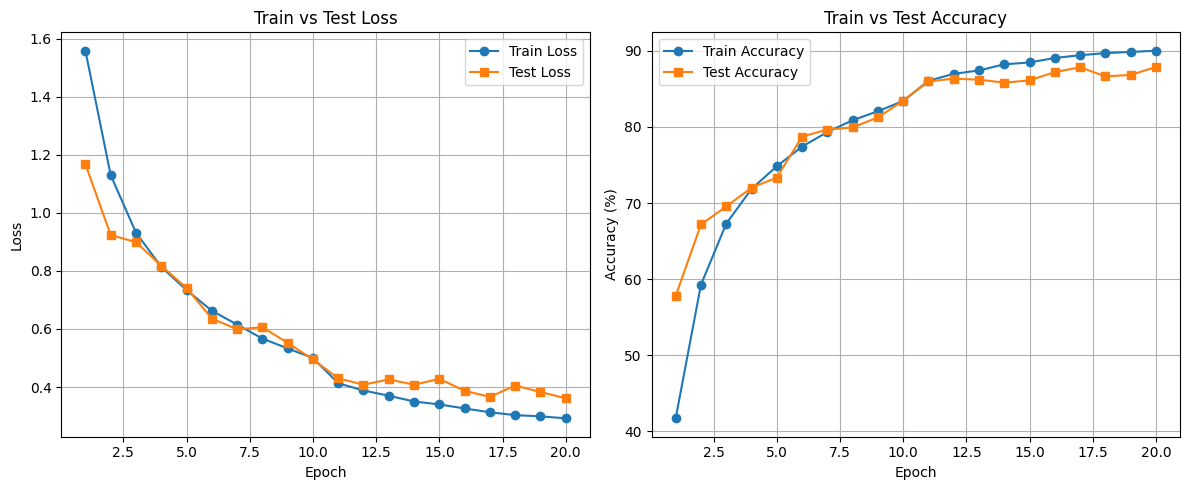

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Ustawienia dla powtarzalnych wyników
torch.manual_seed(0)

def prepare_data():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    batch_size = 128

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_and_evaluate(net, trainloader, testloader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        net.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        net.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(testloader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

    return train_losses, train_accuracies, test_losses, test_accuracies

trainloader, testloader = prepare_data()
net = CNN()
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(net, trainloader, testloader, num_epochs=50)

# Wykresy wyników
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()